<a href="https://colab.research.google.com/github/AdityaSubramanianSudhakar/Digital-Destroyer/blob/main/Text_Classification_Using_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"
)

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
import os

os.listdir(path)


['IMDB Dataset.csv']

In [ ]:
import pandas as pd

df = pd.read_csv(os.path.join(path, "IMDB Dataset.csv"))

df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df['sentiment'].value_counts()


,count
sentiment,
positive,25000
negative,25000


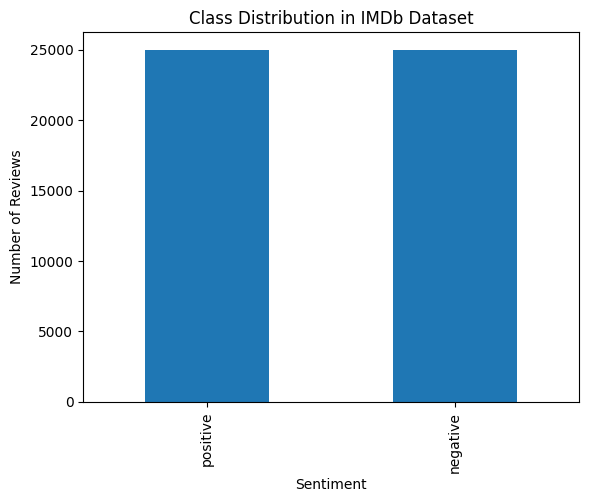

In [ ]:
import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar')
plt.title("Class Distribution in IMDb Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 40000
Testing samples: 10000


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(
    stop_words='english',
    max_features=5000
)

X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

print("BoW Feature Shape:", X_train_bow.shape)


BoW Feature Shape: (40000, 5000)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Feature Shape:", X_train_tfidf.shape)


TF-IDF Feature Shape: (40000, 5000)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

linear_svm = LinearSVC()
linear_svm.fit(X_train_tfidf, y_train)

y_pred_linear = linear_svm.predict(X_test_tfidf)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_linear))
print(classification_report(y_test, y_pred_linear))


Linear SVM Accuracy: 0.8772
              precision    recall  f1-score   support

    negative       0.88      0.87      0.87      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Use a subset for non-linear SVM to reduce computation
X_train_small = X_train_tfidf[:8000]
y_train_small = y_train.iloc[:8000]

rbf_svm = SVC(kernel='rbf', C=1, gamma='scale')
rbf_svm.fit(X_train_small, y_train_small)

y_pred_rbf = rbf_svm.predict(X_test_tfidf)

print("RBF SVM Accuracy (Subset):", accuracy_score(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))


RBF SVM Accuracy (Subset): 0.8692
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      4961
    positive       0.86      0.89      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Reuse the same subset used for RBF
poly_svm = SVC(kernel='poly', degree=3, C=1)

poly_svm.fit(X_train_small, y_train_small)

y_pred_poly = poly_svm.predict(X_test_tfidf)

print("Polynomial SVM Accuracy (Subset):", accuracy_score(y_test, y_pred_poly))


Polynomial SVM Accuracy (Subset): 0.8261


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01]
}

grid = GridSearchCV(
    SVC(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train_small, y_train_small)


In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation F1 Score:", grid.best_score_)


Best Parameters: {'C': 1, 'gamma': 'scale'}
Best Cross-Validation F1 Score: 0.8605459469312906


In [ ]:
from sklearn.metrics import classification_report

best_svm = grid.best_estimator_

y_pred_best = best_svm.predict(X_test_tfidf)

print("Optimized SVM Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Optimized SVM Accuracy: 0.8692
              precision    recall  f1-score   support

    negative       0.88      0.85      0.87      4961
    positive       0.86      0.89      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8493
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      4961
    positive       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Linear SVM",
        "RBF SVM (Subset)",
        "Polynomial SVM (Subset)",
        "Optimized RBF SVM",
        "Random Forest"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_linear),
        accuracy_score(y_test, y_pred_rbf),
        accuracy_score(y_test, y_pred_poly),
        accuracy_score(y_test, y_pred_best),
        accuracy_score(y_test, y_pred_rf)
    ]
})

results


,Model,Accuracy
0,Linear SVM,0.8772
1,RBF SVM (Subset),0.8692
2,Polynomial SVM (Subset),0.8261
3,Optimized RBF SVM,0.8692
4,Random Forest,0.8493


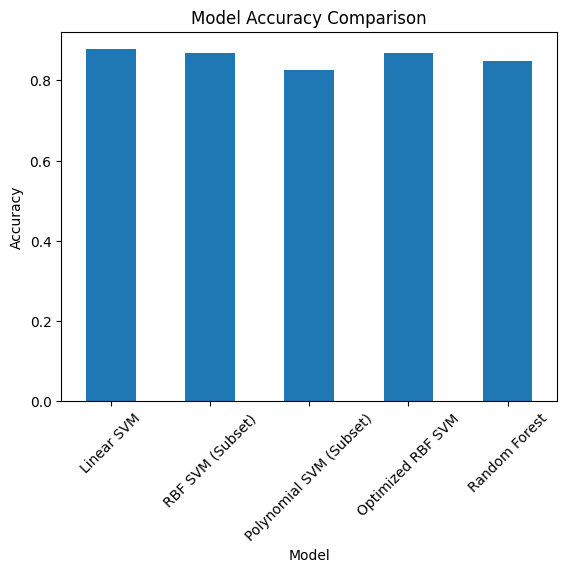

In [ ]:
results.plot(
    x='Model',
    y='Accuracy',
    kind='bar',
    legend=False
)

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()
